### 1.1 Importar Libs

In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import pickle
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# Importar funções dos módulos customizados
from ml_utils import gmean_score, evaluate_model, load_and_prepare_datasets
from search_utils import (plot_search_history, multiple_randomized_search,
                          plot_search_history_from_loaded, 
                          load_search_results, get_best_params_from_saved,
                          save_search_results, save_final_results)

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

### 1.2 Definir Nome do Modelo

In [ ]:
# Definir nome do modelo para uso em salvamento e exibição
MODEL_NAME = "Neural_Committee"
print(f"Modelo: {MODEL_NAME}")

### 1.3 Definir Comitê de Redes Neurais

In [ ]:
# ======================================================================
# COMITÊ DE REDES NEURAIS - IMPLEMENTAÇÃO
# ======================================================================

from sklearn.base import BaseEstimator, ClassifierMixin

class NeuralNetworkCommittee(BaseEstimator, ClassifierMixin):
    def __init__(self, n_networks=5, hidden_layer_sizes=(100,), alpha=0.0001,
                 learning_rate_init=0.001, max_iter=200, activation='relu',
                 solver='adam', voting='soft', learning_rate='constant', random_state=None):
        """
        Comitê de Redes Neurais usando VotingClassifier
        
        Parameters:
        -----------
        n_networks : int
            Número de redes neurais no comitê
        voting : str
            Tipo de votação ('hard' ou 'soft')
        """
        self.n_networks = n_networks
        self.hidden_layer_sizes = hidden_layer_sizes
        self.alpha = alpha
        self.learning_rate_init = learning_rate_init
        self.max_iter = max_iter
        self.activation = activation
        self.solver = solver
        self.voting = voting
        self.learning_rate = learning_rate
        self.random_state = random_state
        
    def fit(self, X, y):
        # Criar diferentes redes neurais com variações nos parâmetros
        networks = []
        
        for i in range(self.n_networks):
            # Variar alguns parâmetros para criar diversidade
            if self.random_state is not None:
                net_random_state = self.random_state + i
            else:
                net_random_state = None
            
            # Criar variações nas arquiteturas
            if i == 0:
                layers = self.hidden_layer_sizes
            elif i == 1:
                layers = tuple([int(x * 1.5) for x in self.hidden_layer_sizes])
            elif i == 2:
                layers = tuple([int(x * 0.75) for x in self.hidden_layer_sizes])
            elif i == 3:
                layers = self.hidden_layer_sizes + (50,)
            else:
                layers = (200, 100) if len(self.hidden_layer_sizes) == 1 else self.hidden_layer_sizes
            
            network = MLPClassifier(
                hidden_layer_sizes=layers,
                alpha=self.alpha * (0.5 + i * 0.3),  # Variar regularização
                learning_rate_init=self.learning_rate_init,
                max_iter=self.max_iter,
                activation=self.activation,
                solver=self.solver,
                random_state=net_random_state,
                early_stopping=True,
                learning_rate=self.learning_rate,
                validation_fraction=0.1
            )
            
            networks.append((f'mlp_{i+1}', network))
        
        # Criar o comitê
        self.committee = VotingClassifier(
            estimators=networks,
            voting=self.voting
        )
        
        # Treinar o comitê
        self.committee.fit(X, y)
        self.classes_ = self.committee.classes_
        
        return self
    
    def predict(self, X):
        return self.committee.predict(X)
    
    def predict_proba(self, X):
        if self.voting == 'soft':
            return self.committee.predict_proba(X)
        else:
            # Para voting='hard', não há predict_proba
            raise AttributeError("predict_proba is not available when voting='hard'")
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

print("Comitê de Redes Neurais definido com sucesso!")

### 1.4 Carregar Datasets

In [ ]:
# Carregamento e preparação inicial dos dados
print("Carregando datasets...")

# Carregar e preparar datasets usando função do módulo
(X_train, X_test, y_train, y_test, 
 X_train_scaled, X_test_scaled, 
 train_data, test_data, scaler) = load_and_prepare_datasets(
    train_path='../dataset_sepsis_prepared.csv',
    test_path='../dataset_sepsis_test_prepared.csv',
    target_column='SepsisLabel',
    scale=True
)

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

In [ ]:
train_data.head()

## 2. Sampling para Busca de Hiperparâmetros

In [ ]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Amostra estratificada do dataset de treino (menor devido à complexidade do comitê)
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.01, 
    stratify=y_train,
    random_state=10
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

## 3 Definir Folds

In [ ]:
# Configuração da validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 4. Comitê Neural - Busca de Hiperparâmetros

In [ ]:
# ======================================================================
# 4.1 BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME} ===")

# Definição do Espaço de Hiperparâmetros para Comitê Neural
param_distributions = {
    'n_networks': [3, 5, 7],  # Número de redes no comitê
    'hidden_layer_sizes': [(100,), (200,), (100, 50), 
                           (200, 100), (150, 75), (300,),
                           (300, 50, 100), (50, 50, 50, 50), (300,200,200),
                           (200, 200, 100), (50, 100, 300, 50), (50,),
                           (400,), (50, 100, 400), (100, 100, 200, 25),
                           (25, 25, 25), (25, 300, 100), (25,), (50,),
                           (100, 300, 50)],  
    'alpha': uniform(0.0001, 0.1),  # Regularização L2
    'learning_rate_init': uniform(0.001, 0.01),  # Taxa de aprendizado inicial
    'max_iter': randint(100, 500),  # Número máximo de iterações
    'activation': ['relu', 'tanh'],  # Função de ativação
    'learning_rate': ['constant', 'adaptive'],  # Estratégia de taxa de aprendizado
    'solver': ['adam', ],  # Otimizador (adam é mais estável para comitês)
    'voting': ['soft']  # Votação soft para melhor performance
}

# Múltiplas execuções do RandomizedSearchCV
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")
model_search, model_all_searches, best_params = multiple_randomized_search(
    estimator=NeuralNetworkCommittee(random_state=42),
    param_distributions=param_distributions,
    X=X_sample,                  
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,               
    n_iter_per_search=20,       
    scoring='f1',
    n_jobs=1,  # Processamento sequencial para evitar conflitos
)

# Seleção da Melhor Configuração
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {model_search.best_score_:.4f}")

In [ ]:
# Registro de Desempenho - plotar evolução
plot_search_history(model_all_searches, model_search, MODEL_NAME)

In [ ]:
# ======================================================================
# 4.5 ANÁLISE DAS MELHORES CONFIGURAÇÕES ENCONTRADAS
# ======================================================================

print(f"=== TOP 10 MELHORES CONFIGURAÇÕES - {MODEL_NAME} ===")

# Extrair os melhores resultados de cada busca
best_configs = []

for i, search_result in enumerate(model_all_searches):
    config = {
        'Busca': i + 1,
        'F1_Score': search_result['best_score'],
        'N_Networks': search_result['best_params']['n_networks'],
        'Hidden_Layers': str(search_result['best_params']['hidden_layer_sizes']),
        'Alpha': search_result['best_params']['alpha'],
        'Learning_Rate_init': search_result['best_params']['learning_rate_init'],
        'Learning_Rate_strat': search_result['best_params']['learning_rate'],
        'Max_Iter': search_result['best_params']['max_iter'],
        'Activation': search_result['best_params']['activation'],
        'Voting': search_result['best_params']['voting']
    }
    best_configs.append(config)

# Converter para DataFrame e ordenar por F1-Score
results_df = pd.DataFrame(best_configs)
results_df = results_df.sort_values('F1_Score', ascending=False).reset_index(drop=True)
results_df['Ranking'] = range(1, len(results_df) + 1)

# Reordenar colunas
results_df = results_df[['Ranking', 'Busca', 'F1_Score', 'N_Networks', 'Hidden_Layers', 
                        'Alpha', 'Learning_Rate_init', 'Learning_Rate_strat', 'Max_Iter', 'Activation', 'Voting']]

# Mostrar tabela formatada
print("Top 10 Configurações (ordenadas por F1-Score Binário):")
print("-" * 150)
print(results_df.to_string(index=False, float_format='%.4f'))

# Estatísticas resumidas
print(f"\n--- ESTATÍSTICAS DAS CONFIGURAÇÕES ---")
print(f"Melhor F1-Score: {results_df['F1_Score'].max():.4f}")
print(f"F1-Score médio: {results_df['F1_Score'].mean():.4f}")
print(f"Desvio padrão: {results_df['F1_Score'].std():.4f}")
print(f"F1-Score mínimo: {results_df['F1_Score'].min():.4f}")

## 5.1 Salvar Resultados de Busca

In [ ]:
# Salvar Resultados da Busca de Hiperparâmetros usando função do módulo
search_df = save_search_results(
    model_name=MODEL_NAME,
    model_search=model_search,
    model_all_searches=model_all_searches,
    n_searches=10,
    n_iter_per_search=5,
    scoring='f1',
    cv_folds=5,
    top_params_columns=['n_networks', 'alpha', 'learning_rate_init', 'max_iter', 'activation', 'voting', 'hidden_layer_sizes'],
    searches_folder='searches'
)

## 5.2 Carregar Resultado de busca

In [25]:
#### 4.2 Carregar Resultados Salvos (Função Auxiliar)
# Exemplo de uso da função (não executar se já temos os resultados)
loaded_results = load_search_results(MODEL_NAME)

=== CARREGANDO RESULTADOS DE BUSCA - NEURAL_COMMITTEE ===
✅ Resultados detalhados carregados: 400 configurações
✅ Resumo carregado: F1-Score = 0.0502
⚠️  Arquivo não encontrado: searches\neural_committee_full_search.pkl


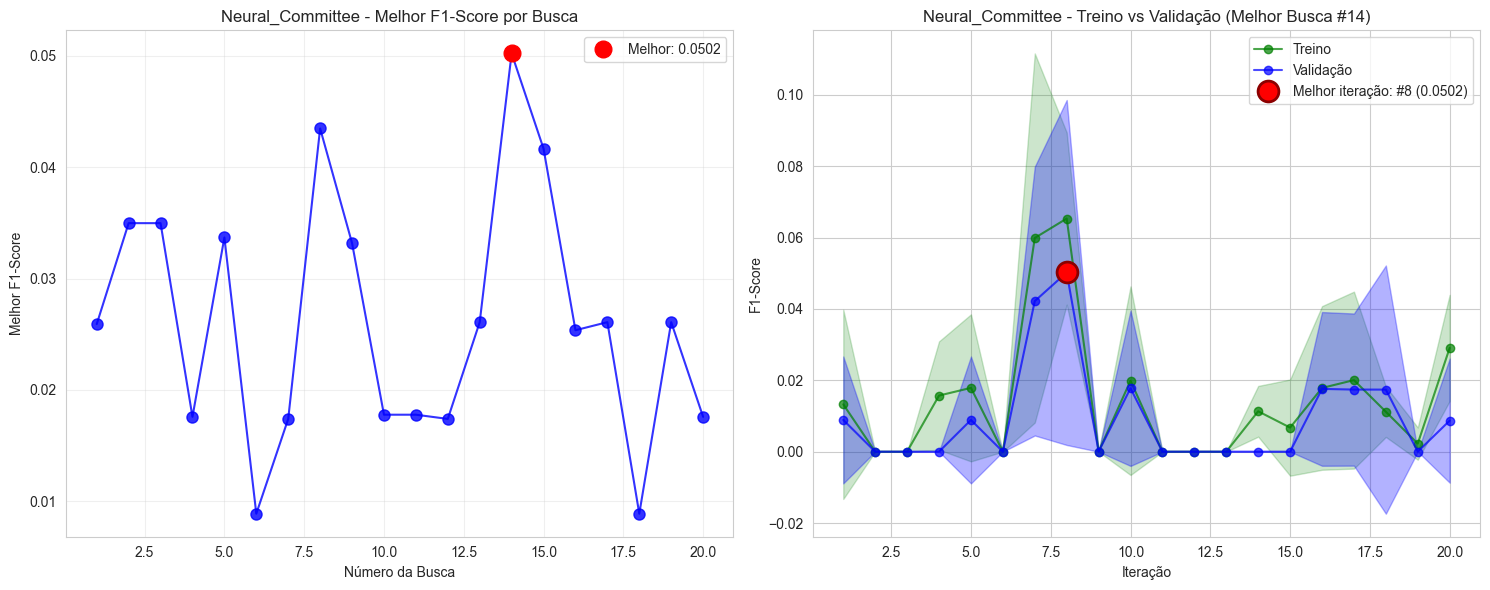

In [26]:
# Plotar a história da busca a partir dos resultados carregados
plot_search_history_from_loaded(loaded_results, MODEL_NAME)

In [ ]:

#### 4.3 Recuperar Melhores Parâmetros para Uso Posterior
# Exemplo de uso (descomente se precisar carregar parâmetros salvos):
if 'loaded_results' in locals():
    best_params = get_best_params_from_saved(MODEL_NAME)
    if best_params:
        print(f"✅ Parâmetros carregados: {best_params}")
    best_score = loaded_results['summary']['best_overall_score']
    print(f"✅ Melhor F1-Score carregado: {best_score:.4f}")
else:
    best_params = model_search.best_params_
    best_score = model_search.best_score_
    print(f"✅ Usando parâmetros da busca atual: {best_params}")
    print(f"✅ Melhor F1-Score da busca atual: {best_score:.4f}")

## 6. Treinar Modelo Final e Salvar

In [ ]:
# Treinamento Final com melhores hiperparâmetros
best_model = NeuralNetworkCommittee(**best_params, random_state=42)
best_model.fit(X_train_scaled, y_train)

print(f"\nModelo final {MODEL_NAME} treinado: {best_model}")

# Criar pasta se não existir
os.makedirs('models', exist_ok=True)

# Salvar modelo treinado
dump(best_model, f'models/{MODEL_NAME.lower()}_trained.joblib')
print(f"Modelo salvo: models/{MODEL_NAME.lower()}_trained.joblib")

## 7. Avaliação Final e Salvamento dos Resultados

In [ ]:
# Carregar modelo
loaded_model = load(f'models/{MODEL_NAME.lower()}_trained.joblib')

In [ ]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pastas se não existirem
os.makedirs('results', exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")

if 'loaded_model' in locals():
    model = loaded_model
else:
    model = best_model

X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo
train_metrics, test_metrics, y_pred = evaluate_model(
    model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)

In [ ]:
# Criar pastas se não existirem
os.makedirs('results', exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")

X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo
train_metrics, test_metrics, y_pred = evaluate_model(
    best_model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)

# Salvar resultados finais usando função do módulo
model_final_results = save_final_results(
    model_name=MODEL_NAME,
    best_params={k: (str(v) if isinstance(v, tuple) else v) for k, v in best_params.items()},
    best_score=model_search.best_score_,
    train_metrics=train_metrics,
    test_metrics=test_metrics,
    y_pred=y_pred,
    y_test=y_test_eval,
    X_train_scaled=X_train_eval,
    X_test_scaled=X_test_eval,
    results_folder='results'
)

# Mostrar resumo
print(f"\n--- RESUMO {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
if test_metrics['auc_roc']:
    print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")